In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import monai
import numpy as np
import matplotlib.pyplot as plt
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
#data_img_path = r'D:\Datasets\Decathlon\Task03_Liver\imagesTr\liver_16.nii.gz'
#data_label_path = r'D:\Datasets\Decathlon\Task03_Liver\labelsTr\liver_16.nii.gz'
data_img_path = "/media/david/T7/Decathlon/Dataset/Task03_Liver/imagesTr/liver_16.nii.gz"
data_label_path = "/media/david/T7/Decathlon/Dataset/Task03_Liver/labelsTr/liver_16.nii.gz"

data_file = {'image': data_img_path, 'label': data_label_path}

In [4]:
load_im = monai.transforms.LoadImaged(keys=['image', 'label'])
chan_f = monai.transforms.AddChanneld(keys=['image', "label"])
scale_intens = monai.transforms.ScaleIntensityRanged(keys='image', a_min=-21, a_max=189, b_min=0, b_max=1,clip=True)
to_t = monai.transforms.ToTensord(keys=["image", "label"])

data = to_t(scale_intens(chan_f(load_im(data_file))))

/home/david/anaconda3/envs/CandidateNet/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [5]:
slice_max = 423

In [6]:
inputs = data['image'][:,:,:,slice_max].unsqueeze(0).to(device)
labels = data['label'][:,:,:,slice_max].unsqueeze(0).to(device)

In [7]:
slice_max

423

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
def visualize_data(im, lab):
    plt.figure()
    plt.imshow(im.squeeze().cpu().numpy(), cmap='gray')
    plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)

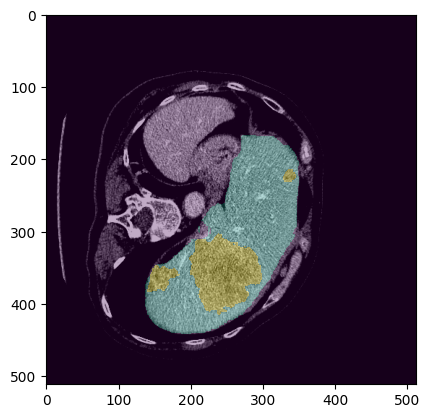

In [10]:
visualize_data(inputs, labels)

In [11]:
class RegularNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(),
                        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(),
                        nn.Conv2d(512, 3, kernel_size=3, stride=1, padding=1))
        
    def forward(self, x):
        return self.net(x)
        
        

In [12]:
def select_entropy_candidates(x, n=5000):
    B, C, H, W = x.shape
    sm = F.softmax(x, dim=1)
    entr = torch.sum(torch.special.entr(sm), dim=1)
    entr = entr.view(B, -1)
    candidates = torch.zeros(B, 1, H, W)
    candidates = candidates.view(B, -1)
    top_e, top_e_ind = torch.topk(entr, n, dim=1, largest=True)
    candidates[:,top_e_ind] = 1
    candidates = candidates.view(B, 1, H, W)
    
    return candidates

In [13]:
class Mlp(nn.Module):
    """ Multilayer perceptron."""

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [14]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

In [15]:
def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

In [16]:
class WindowAttention(nn.Module):
    """ Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """ Forward function.

        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [17]:
class SwinTransformerBlock(nn.Module):
    """ Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, num_heads, window_size=7,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        """ Forward function.

        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
            mask_matrix: Attention mask for cyclic shift.
        """
        B, L, C = x.shape

        shortcut = x
        x = self.norm1(x)

        # W-MSA/SW-MSA
        attn_windows = self.attn(x)  # nW*B, window_size*window_size, C

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

In [18]:
class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of feature channels
        depth (int): Depths of this stage.
        num_heads (int): Number of attention head.
        window_size (int): Local window size. Default: 7.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self,
                 dim,
                 depth,
                 num_heads,
                 window_size=7,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.window_size = window_size
        self.depth = depth
        
        # build blocks
        self.blocks = nn.ModuleList()
        for i_block in range(depth):
            block = SwinTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer)
            self.blocks.append(block)

    def forward(self, x):
        """ Forward function.

        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """
        for blk in self.blocks:
            x = blk(x)

        return x

In [19]:
from torch.nn.modules.loss import _Loss
from torch.nn import CrossEntropyLoss
from monai.networks.utils import one_hot
class MetaLoss(_Loss):
    def __init__(self):
        super().__init__(reduction='mean')
        self.ce_l = CrossEntropyLoss(reduction='none')
        self.dice = monai.losses.DiceLoss(
            include_background=True,
            to_onehot_y=True,
            sigmoid=False,
            softmax=True
        )
        self.alpha = 0.5
    
    def forward(self, outputs_initial, outputs_candidate, target, candidate_scores):
        B,S,H,W = candidate_scores.shape
        
        ce_loss_init = self.ce_l(outputs_initial, target.squeeze(1))
        ce_loss_cand = self.ce_l(outputs_candidate, target.squeeze(1))
        
        ce_loss_improvement = ce_loss_init - ce_loss_cand
        
        #candidate_scores = candidate_scores - candidate_scores.min()
        #candidate_scores = candidate_scores / candidate_scores.max()
        cm = F.softmax(candidate_scores.view(B,-1), dim=1)
        cm = cm.view(B,S,H,W)
        
        meta_loss = self.alpha*(cm * (1 - ce_loss_improvement))
        
        dice_loss = self.dice(outputs_candidate, target)
        
        
        #loss = ce_loss_init.mean() + ce_loss_cand.mean() + self.alpha * meta_loss.mean() + dice_loss
        
        return ce_loss_init.mean(), ce_loss_cand.mean(), meta_loss.mean(), dice_loss

In [20]:
class CandidateNetwork(nn.Module):
    def __init__(self, n_candidates, input_h, input_w, cand_net=True, use_attn=True):
        super().__init__()
        self.n_candidates = n_candidates
        self.input_h = input_h
        self.input_w = input_w
        
        dim = 96
        self.dim = dim
        self.depths = [2]
        self.num_layers = len(self.depths)
        self.num_heads = [8]
        self.window_size = 16
        self.random_c_ratio = 0.00
        
        self.net = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                         nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.Conv2d(128, dim, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(dim),
                        nn.ReLU())
        self.out1 = nn.Conv2d(dim, 3, kernel_size=3, stride=1, padding=1)
        
        self.cand_net = cand_net
        self.use_attn = use_attn
        
        if self.cand_net:

            if self.use_attn:
                self.layers = nn.ModuleList()
                for i_layer in range(self.num_layers):
                    layer = BasicLayer(
                        dim=self.dim,
                        depth=self.depths[i_layer],
                        num_heads=self.num_heads[i_layer],
                        window_size=self.window_size,
                        mlp_ratio=4.0,
                        qkv_bias=True)
                    self.layers.append(layer)

                self.out2 = nn.Linear(dim, 3)
            else:
                self.layers = nn.Sequential(nn.Conv2d(self.dim, self.dim, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(self.dim),
                        nn.ReLU(),
                         nn.Conv2d(self.dim, self.dim, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(self.dim),
                        nn.ReLU(),
                         nn.Conv2d(self.dim, self.dim, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(self.dim),
                        nn.ReLU())
                self.out2 = nn.Conv2d(dim, 3, kernel_size=3, stride=1, padding=1)
            
            self.candidate_selector = nn.Sequential(nn.Linear(dim, dim // 2),
                                                    nn.ReLU(),
                                                    nn.Linear(dim // 2, 1))
        
        
    def select_entropy_candidates(self, x):
        B, C, H, W = x.shape
        sm = self.softmax(x)
        entr = torch.sum(torch.special.entr(sm), dim=1)
        entr = entr.view(B, -1)
        top_e, top_e_ind = torch.topk(entr, self.n_candidates, dim=1, largest=True)
        candidates = torch.zeros(B, 1, H, W).bool()
        candidates = candidates.view(B, -1)
        candidates[:,top_e_ind] = True
        candidates = candidates.view(B, 1, H, W)
        candidate_mask = candidates.permute(0,2,3,1).bool()#.squeeze(3)
        #pos = torch.nonzero(candidate_mask, as_tuple=True)
        return candidate_mask
    
    def select_entropy_candidates_all(self, x):
        B, C, H, W = x.shape
        x = x - x.min(1, keepdim=True)[0]
        x =x / x.max(1, keepdim=True)[0]
        #sm = self.softmax(x)
        entr = torch.sum(torch.special.entr(x), dim=1)
        entr = entr.unsqueeze(3)
        return entr
    
    def select_logit_candidates_all(self, x):
        B, C, H, W = x.shape
        entr = torch.sum(x, dim=1)
        entr = entr.unsqueeze(3)
        return entr
    
    def select_learned_candidates(self, x):
        B, C, H, W = x.shape
        candidate_scores = self.candidate_selector(x.permute(0, 2, 3, 1))
        
        return candidate_scores
        
        
    def forward(self, x):
        features = self.net(x)
        B, C, H, W = features.shape
        N = H * W
        
        first_pred = self.out1(features)
        
        initial_pred = first_pred
        
        
        visual_sel_windows = None
        cm = None

        
        if self.cand_net:
            
            #cm = self.select_entropy_candidates(first_pred.detach())
            #cm = self.select_entropy_candidates_all(first_pred)
            #cm = self.select_logit_candidates_all(features.detach())
            cm = self.select_learned_candidates(features)
            #cm = torch.argmax(candidate_scores, dim=3).unsqueeze(3)
            
            features = features.permute(0, 2, 3, 1)
            features_windowed = window_partition(features, self.window_size)
            features_windowed = features_windowed.view(-1, self.window_size * self.window_size, C)
            n_windows = features_windowed.shape[0]
            
            cm_windowed = window_partition(cm, self.window_size)
            cm_windowed = cm_windowed.view(-1, self.window_size * self.window_size)
            
            
            window_score_sum = cm_windowed.sum(dim=1)
            _, ind_sel_win = torch.topk(window_score_sum, n_windows // 16, dim=0, largest=True)

            if self.random_c_ratio > 0:
                n_sel_windows = int(self.random_c_ratio*n_windows)
                rsi = torch.multinomial(torch.arange(n_windows).float(), n_sel_windows)
                ind_sel_win = torch.cat([rsi.to(device), ind_sel_win]).unique()
            
            sel_features = features_windowed[ind_sel_win]
            
            visual_sel_windows = torch.zeros(n_windows, self.window_size * self.window_size, 1)
            visual_sel_windows[ind_sel_win] = 1
            visual_sel_windows = window_reverse(visual_sel_windows, self.window_size, self.input_h, self.input_w)
            visual_sel_windows = visual_sel_windows.permute(0, 3, 1, 2)

            if self.use_attn:
                for i in range(self.num_layers):
                    layer = self.layers[i]
                    sel_features = layer(sel_features)

                y = self.out2(sel_features)
            else:
                sel_features = sel_features.view(-1, self.window_size, self.window_size, self.dim)
                sel_features = sel_features.permute(0, 3, 1, 2)
                sel_features = self.layers(sel_features)

                y = self.out2(sel_features)
                y = y.view(-1, 3, self.window_size * self.window_size).permute(0, 2, 1)

            first_pred = first_pred.permute(0, 2, 3, 1)
            first_pred = window_partition(first_pred, self.window_size)
            first_pred = first_pred.view(-1, self.window_size * self.window_size, 3)
            first_pred[ind_sel_win] = y

            first_pred = window_reverse(first_pred, self.window_size, self.input_h, self.input_w)
            first_pred = first_pred.permute(0, 3, 1, 2)
            cm = cm.permute(0, 3, 1, 2)
        
        return first_pred, visual_sel_windows, cm, initial_pred
        

In [21]:
model = CandidateNetwork(n_candidates=10000, input_h=512, input_w=512, cand_net=True, use_attn=True)
model.to(device)
print(count_parameters(model))

450647


/home/david/anaconda3/envs/CandidateNet/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 99, Dice score: 0.737, init ce loss: 0.149, cand ce loss: 0.148, meta loss: 0.000, tot loss: 0.577
Epoch: 199, Dice score: 0.801, init ce loss: 0.097, cand ce loss: 0.094, meta loss: 0.000, tot loss: 0.360
Epoch: 299, Dice score: 0.836, init ce loss: 0.076, cand ce loss: 0.073, meta loss: 0.000, tot loss: 0.271
Epoch: 399, Dice score: 0.859, init ce loss: 0.059, cand ce loss: 0.058, meta loss: 0.000, tot loss: 0.214
Epoch: 499, Dice score: 0.877, init ce loss: 0.046, cand ce loss: 0.045, meta loss: 0.000, tot loss: 0.165
Epoch: 599, Dice score: 0.890, init ce loss: 0.043, cand ce loss: 0.041, meta loss: 0.000, tot loss: 0.144
Epoch: 699, Dice score: 0.901, init ce loss: 0.032, cand ce loss: 0.030, meta loss: 0.000, tot loss: 0.110


/tmp/ipykernel_260383/1065607001.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Epoch: 799, Dice score: 0.911, init ce loss: 0.026, cand ce loss: 0.024, meta loss: 0.000, tot loss: 0.090
Epoch: 899, Dice score: 0.919, init ce loss: 0.021, cand ce loss: 0.018, meta loss: 0.000, tot loss: 0.068
Epoch: 999, Dice score: 0.925, init ce loss: 0.017, cand ce loss: 0.014, meta loss: 0.000, tot loss: 0.055


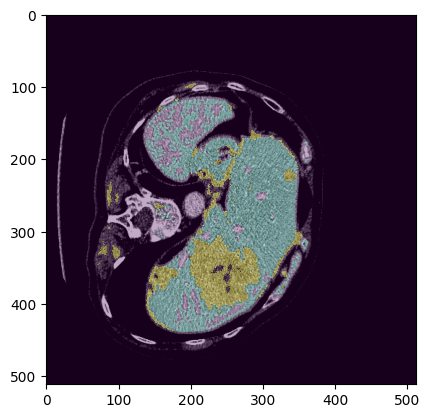

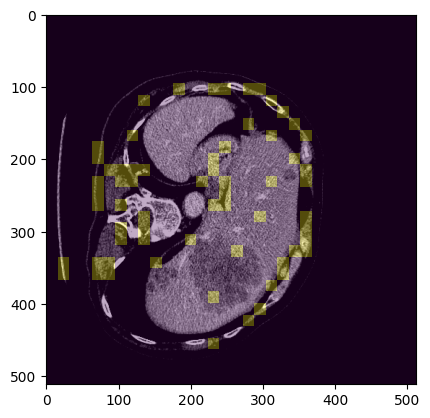

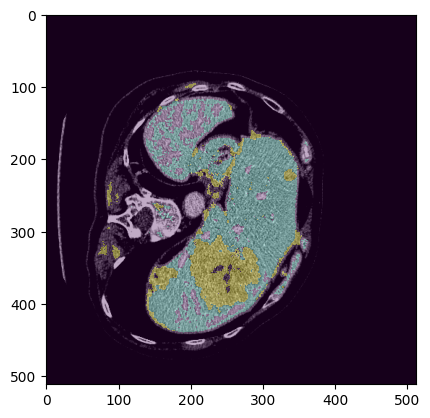

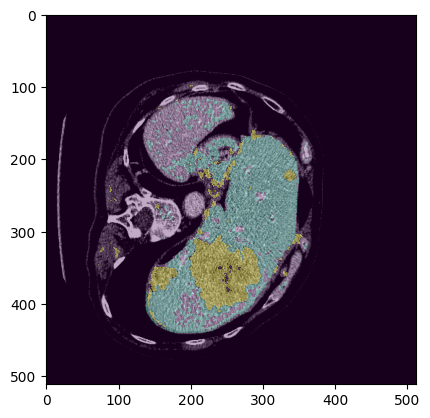

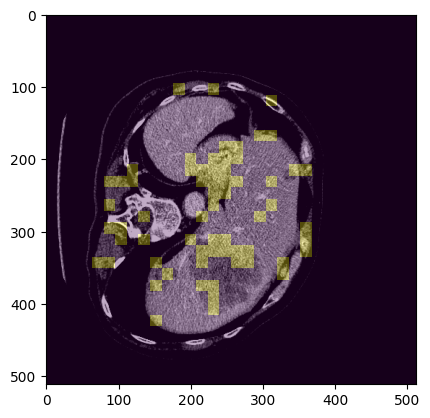

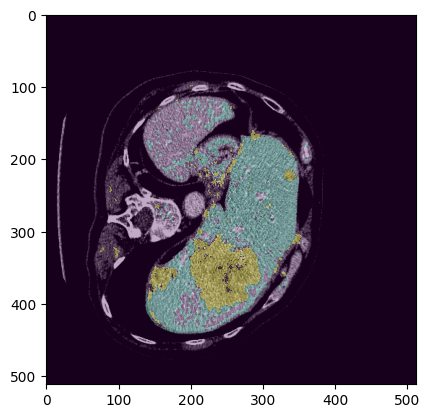

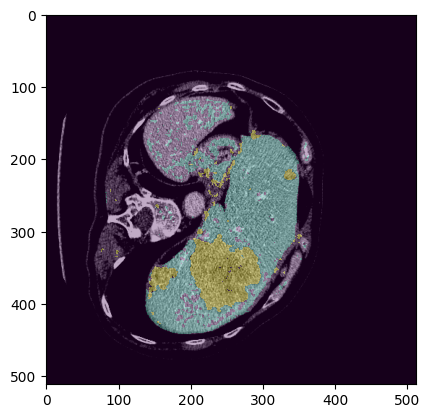

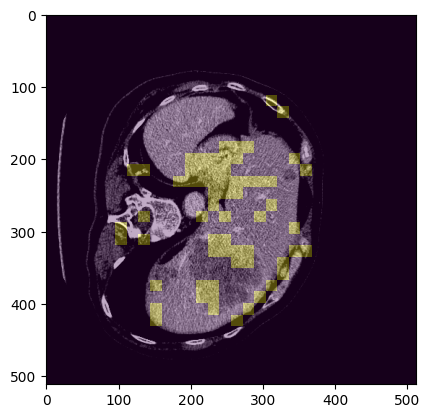

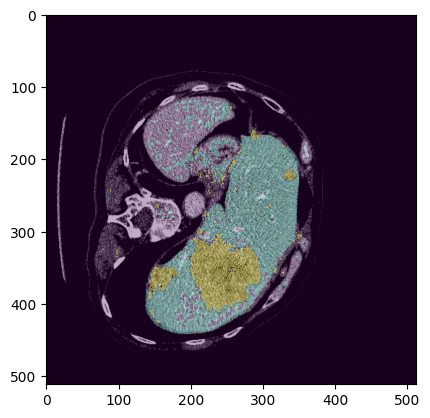

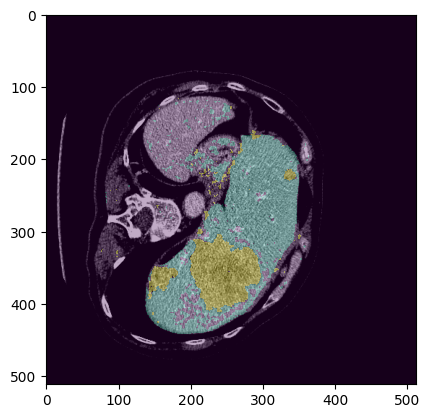

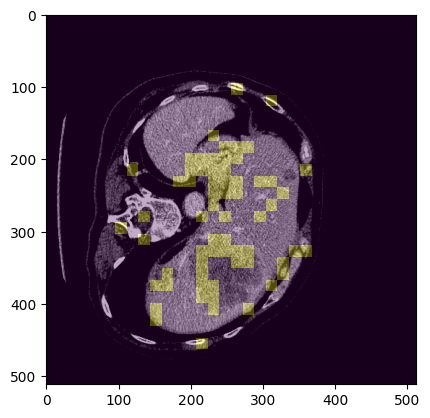

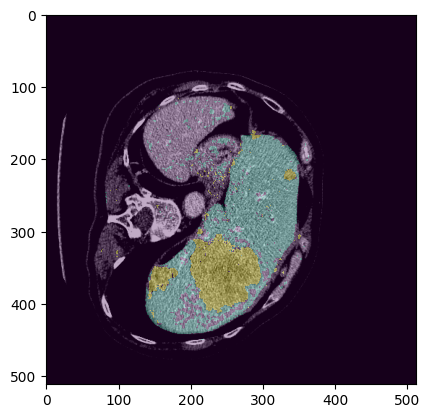

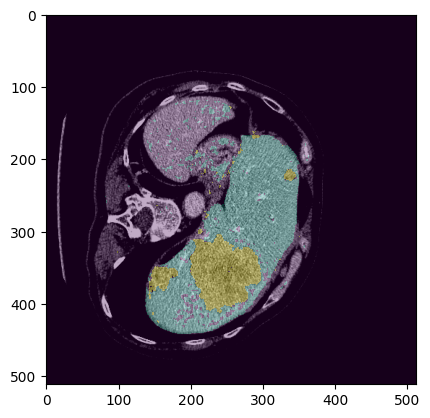

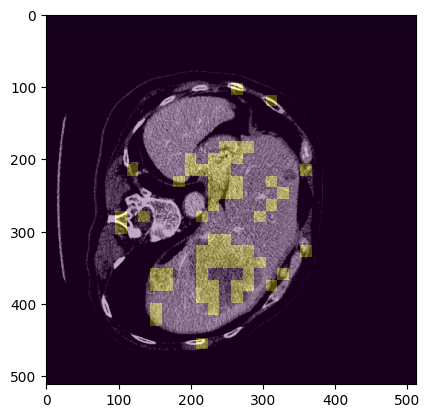

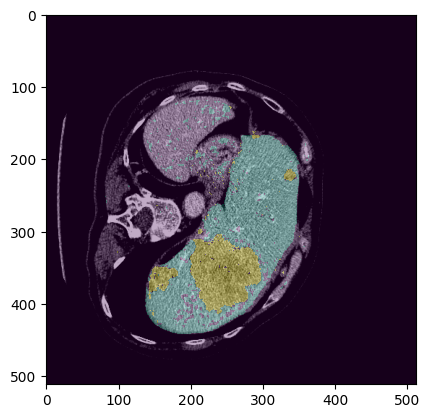

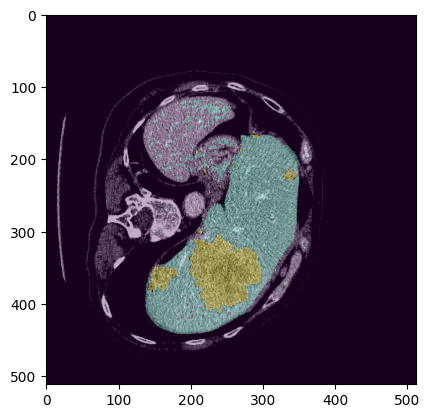

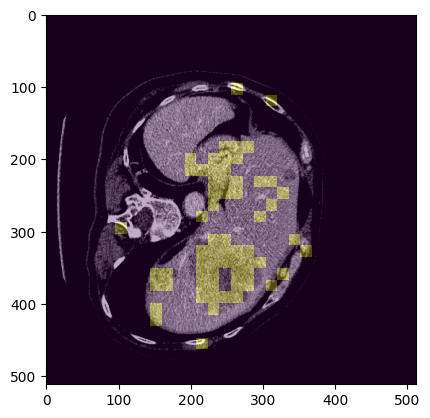

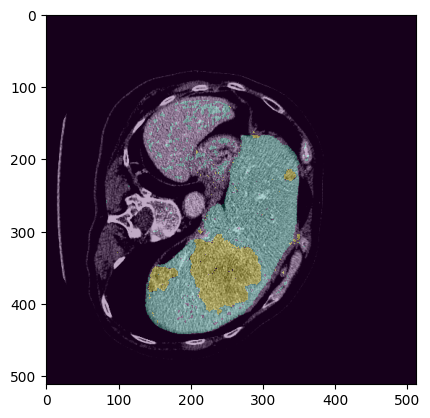

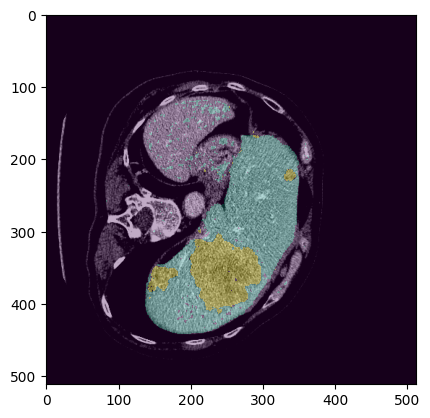

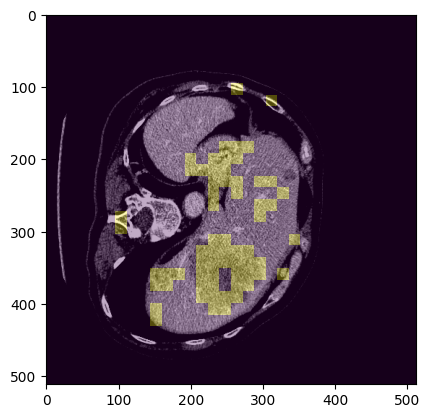

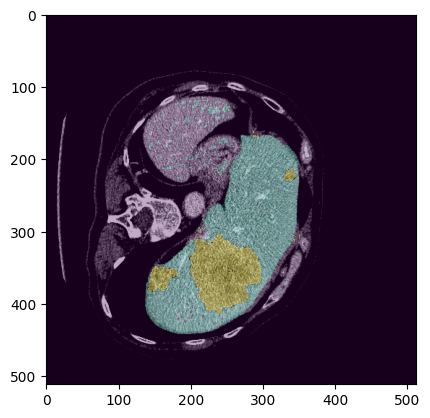

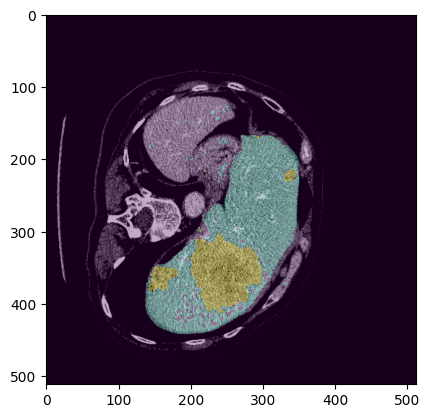

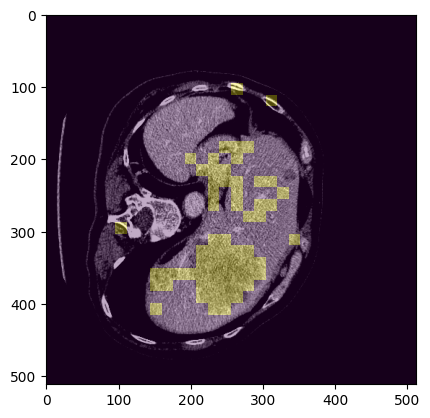

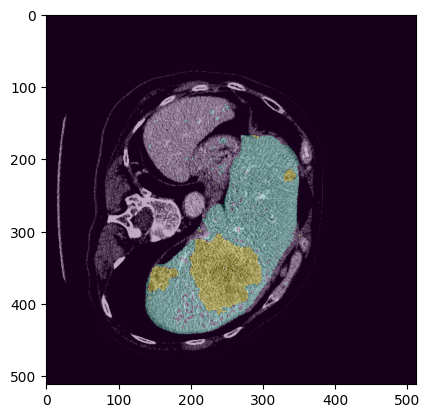

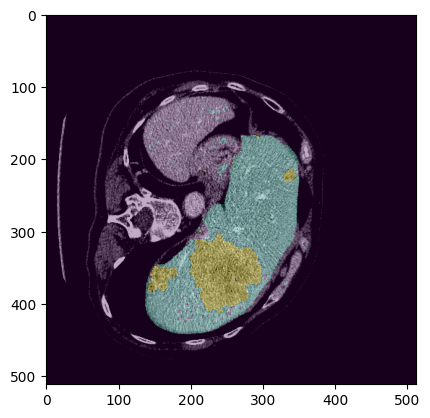

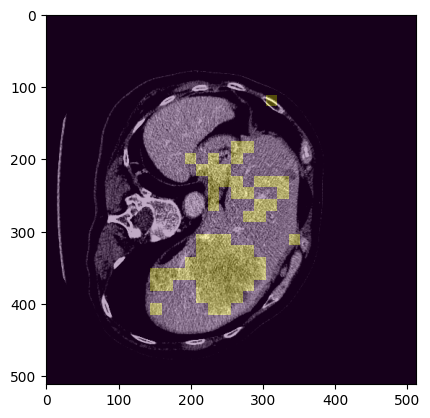

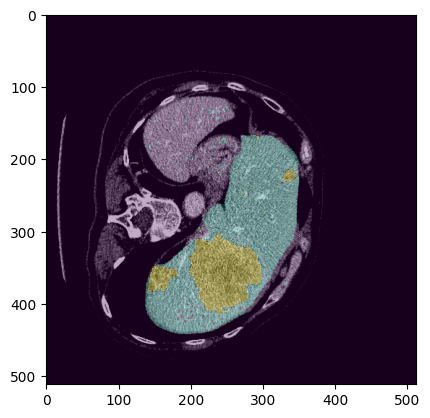

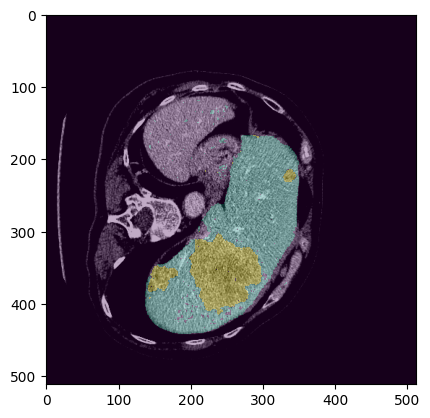

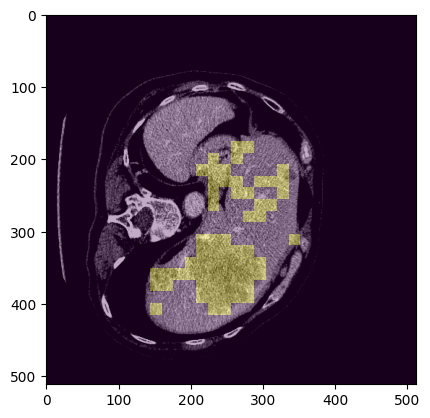

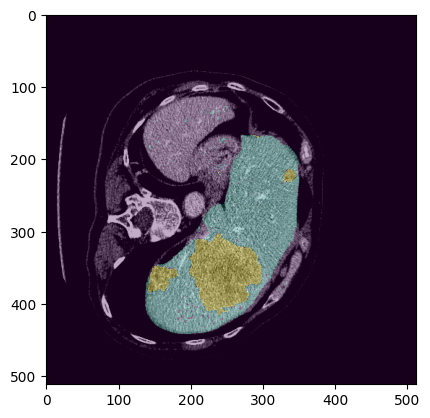

In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = monai.losses.DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=False)
post_label = monai.transforms.AsDiscrete(to_onehot=3)
post_pred = monai.transforms.AsDiscrete(argmax=True, to_onehot=3)
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
lossloss = MetaLoss()
epochs = 1000
total_prints = 10
print_every_n_epochs = epochs // total_prints


for e in range(epochs):
    outputs, visual_sel_windows, cs, init_outputs = model(inputs)
    if cs is None:
        loss = criterion(outputs, labels)
    else:
        ce_loss_init, ce_loss_cand, meta_loss, dice_loss = lossloss(init_outputs, outputs, labels.long(), cs)
        loss = ce_loss_init + ce_loss_cand + meta_loss + dice_loss

    #aux_loss = lossloss(outputs, labels, candidate_scores)
    #tot_loss = loss + 0.5*aux_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    labels_convert = [post_label(labels[0])]
    output_convert = [post_pred(outputs[0])]
    dice_metric(y_pred=output_convert, y=labels_convert)
    dice_scores, dice_not_nans = dice_metric.aggregate()
    if ((e + 1) % print_every_n_epochs) == 0:
        if not visual_sel_windows is None:
            init_pred = torch.argmax(init_outputs, dim=1)
            visualize_data(inputs, init_pred)
            visualize_data(inputs, visual_sel_windows)
            print("Epoch: {}, Dice score: {:.3f}, init ce loss: {:.3f}, cand ce loss: {:.3f}, meta loss: {:.3f}, tot loss: {:.3f}".format(e, dice_scores.item(), ce_loss_init.item(), ce_loss_cand.item(), meta_loss.item(), loss.item()))
        else:
            print("Epoch: {}, Dice score: {}, loss: {}".format(e, dice_scores.item(), loss.item()))
        pred = torch.argmax(outputs, dim=1)
        visualize_data(inputs, pred)
